## Khai báo thư viện

In [6]:
import cv2
import numpy as np
from pathlib import Path
from tqdm.notebook import tqdm 
import matplotlib.pyplot as plt

# Tắt cảnh báo không cần thiết
import warnings
warnings.filterwarnings('ignore')
import traceback

## Chuẩn hoá đường dẫn lưu trữ file

In [ ]:
# ==== Tham số ====
PROJECT_DIR = Path.cwd().parent 

# Đường dẫn đến thư mục dữ liệu
DATA_DIR = PROJECT_DIR / "data"
INTERIM_DIR = DATA_DIR / "02_interim"
PROCESSED_DIR = DATA_DIR / "03_processed"

# Tạo thư mục đầu ra nếu chưa tồn tại
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)

print(f"Project Dir:     {PROJECT_DIR}")
print(f"Interim Dir (In):  {INTERIM_DIR}")
print(f"Processed Dir (Out): {PROCESSED_DIR}")


Thư mục dữ liệu tạm thời (đầu vào): /Users/CONG HAU/UIT-CS-PROJECTS/CS231 - Introduction to Computer Vision/data/02_interim
Thư mục dữ liệu đã xử lý (đầu ra): /Users/CONG HAU/UIT-CS-PROJECTS/CS231 - Introduction to Computer Vision/data/03_processed


## Chuẩn bị data

Đang tải: train_data.npz...
Đã tải thành công train_data.npz. X: (8226, 224, 224, 3), y: (8226,)
Đang tải: val_data.npz...
Đã tải thành công train_data.npz. X: (8226, 224, 224, 3), y: (8226,)
Đang tải: val_data.npz...
Đã tải thành công val_data.npz. X: (2742, 224, 224, 3), y: (2742,)
Đang tải: test_data.npz...
Đã tải thành công val_data.npz. X: (2742, 224, 224, 3), y: (2742,)
Đang tải: test_data.npz...
Đã tải thành công test_data.npz. X: (2743, 224, 224, 3), y: (2743,)

Hiển thị ảnh mẫu từ tập TRAIN:
Đã tải thành công test_data.npz. X: (2743, 224, 224, 3), y: (2743,)

Hiển thị ảnh mẫu từ tập TRAIN:


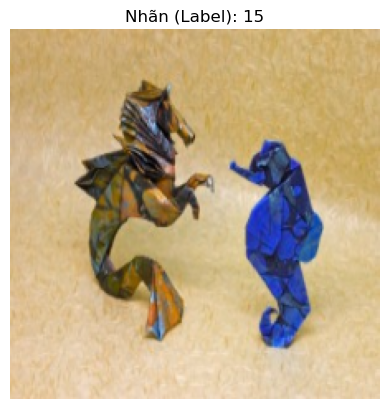

In [9]:
def load_data_split(data_dir, filename):
    """Tải file .npz từ thư mục chỉ định và trả về X, y."""
    data_path = data_dir / filename
    
    if not data_path.exists():
        print(f"CẢNH BÁO: Không tìm thấy file tại '{data_path}'.")
        print("Sẽ trả về (None, None).")
        return None, None
    
    try:
        print(f"Đang tải: {filename}...")
        data = np.load(data_path)
        X = data['X']
        y = data['y']
        print(f"Đã tải thành công {filename}. X: {X.shape}, y: {y.shape}")
        return X, y
    except Exception as e:
        print(f"Lỗi khi tải '{data_path}': {e}")
        return None, None

# ---- 3. Tải cả 3 tập dữ liệu ----
X_train, y_train = load_data_split(INTERIM_DIR, 'train_data.npz')
X_val,   y_val   = load_data_split(INTERIM_DIR, 'val_data.npz')
X_test,  y_test  = load_data_split(INTERIM_DIR, 'test_data.npz')

# ---- 4. Hiển thị ảnh mẫu (từ tập train) ----
if X_train is not None and X_train.shape[0] > 0:
    print("\nHiển thị ảnh mẫu từ tập TRAIN:")
    sample_image = X_train[0]
    
    if sample_image.ndim == 3 and sample_image.shape[2] == 3:
        plt.imshow(cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB))
    elif sample_image.ndim == 2:
        plt.imshow(sample_image, cmap='gray')
    else:
        plt.imshow(sample_image)
       
    plt.title(f"Nhãn (Label): {y_train[0]}")
    plt.axis('off')
    plt.show()
else:
    print("Không có dữ liệu tập train để hiển thị.")

## Trích xuất đặc trưng

### Color Histogram

In [13]:
def extract_color_histogram(image, bins=(8, 8, 8)):
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hist = cv2.calcHist([hsv_image], [0, 1, 2], None, bins,
                        [0, 180, 0, 256, 0, 256])
    cv2.normalize(hist, hist)
    return hist.flatten()

### Sharpen Detection

In [14]:
def extract_sharpen_features(image, hist_bins=256):
    # 1. Chuyển sang ảnh xám
    if image.ndim == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image

    # 2. Định nghĩa kernel "sharpen"
    kernel = np.array([[ 0, -1,  0],
                       [-1,  5, -1],
                       [ 0, -1,  0]])
    
    # 3. Áp dụng bộ lọc
    sharpened_img = cv2.filter2D(gray, -1, kernel)
    
    # 4. Tính histogram của ảnh đã làm nét
    hist = cv2.calcHist([sharpened_img], [0], None, [hist_bins], [0, 256])
    
    # Normalize histogram
    cv2.normalize(hist, hist)
    
    # Flatten
    return hist.flatten()

### Thực hiện trích xuất

In [20]:
def process_dataset(X_data, y_data, desc="Processing"):
    # Trả về None nếu đầu vào là None
    if X_data is None:
        print(f"Bỏ qua {desc} vì X_data là None.")
        return None, None, None, None

    features_hist = []
    features_sharp = []

    for img in tqdm(X_data, desc=desc):
        # Chuẩn hóa ảnh về uint8 nếu cần
        if img.dtype != np.uint8:
            img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

        # Đảm bảo ảnh là 3 channel cho Color Histogram
        if img.ndim == 2:
            img_bgr = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
        else:
            img_bgr = img

        # PP1: Color Histogram
        hist_feats = extract_color_histogram(img_bgr)
        features_hist.append(hist_feats)
        
        # PP2: Sharpen Detection
        sharp_feats = extract_sharpen_features(img_bgr)
        features_sharp.append(sharp_feats)

    # Chuyển đổi
    X_hist = np.array(features_hist)
    X_sharp = np.array(features_sharp)
    
    # Kết hợp
    X_combined = np.hstack([X_hist, X_sharp])
    
    print(f"Hoàn tất {desc}!")
    print(f"  Shape Hist:      {X_hist.shape}")
    print(f"  Shape Sharp:     {X_sharp.shape}")
    print(f"  Shape Combined:  {X_combined.shape}")
    
    return X_hist, X_sharp, X_combined, y_data

## Xuất file đặc trưng

In [21]:
# ---- Xử lý tập TRAIN ----
(X_train_hist, X_train_sharp, 
 X_train_comb, y_train) = process_dataset(X_train, y_train, desc="Processing TRAIN set")

# ---- Xử lý tập VALIDATION ----
(X_val_hist, X_val_sharp, 
 X_val_comb, y_val) = process_dataset(X_val, y_val, desc="Processing VALIDATION set")

# ---- Xử lý tập TEST ----
(X_test_hist, X_test_sharp, 
 X_test_comb, y_test) = process_dataset(X_test, y_test, desc="Processing TEST set")

Processing TRAIN set:   0%|          | 0/8226 [00:00<?, ?it/s]

Hoàn tất Processing TRAIN set!
  Shape Hist:      (8226, 512)
  Shape Sharp:     (8226, 256)
  Shape Combined:  (8226, 768)


Processing VALIDATION set:   0%|          | 0/2742 [00:00<?, ?it/s]

Hoàn tất Processing VALIDATION set!
  Shape Hist:      (2742, 512)
  Shape Sharp:     (2742, 256)
  Shape Combined:  (2742, 768)


Processing TEST set:   0%|          | 0/2743 [00:00<?, ?it/s]

Hoàn tất Processing TEST set!
  Shape Hist:      (2743, 512)
  Shape Sharp:     (2743, 256)
  Shape Combined:  (2743, 768)


In [23]:
def save_features(output_dir, filename, X_hist, X_sharp, X_combined, y):
    # Chỉ lưu nếu dữ liệu tồn tại
    if X_combined is not None and y is not None:
        output_path = output_dir / filename
        
        np.savez(
            output_path,
            X_hist=X_hist,
            X_sharp=X_sharp,
            X_combined=X_combined,
            y=y
        )
        print(f"Đã lưu đặc trưng vào: '{output_path}'")
    else:
        print(f"Bỏ qua lưu file '{filename}' do không có dữ liệu.")

# Lưu 3 file riêng biệt
save_features(PROCESSED_DIR, 'train_features.npz', 
              X_train_hist, X_train_sharp, X_train_comb, y_train)

save_features(PROCESSED_DIR, 'val_features.npz', 
              X_val_hist, X_val_sharp, X_val_comb, y_val)

save_features(PROCESSED_DIR, 'test_features.npz', 
              X_test_hist, X_test_sharp, X_test_comb, y_test)

print("\nHoàn tất toàn bộ quá trình trích xuất và lưu trữ!")

Đã lưu đặc trưng vào: '/Users/CONG HAU/UIT-CS-PROJECTS/CS231 - Introduction to Computer Vision/data/03_processed/train_features.npz'
Đã lưu đặc trưng vào: '/Users/CONG HAU/UIT-CS-PROJECTS/CS231 - Introduction to Computer Vision/data/03_processed/val_features.npz'
Đã lưu đặc trưng vào: '/Users/CONG HAU/UIT-CS-PROJECTS/CS231 - Introduction to Computer Vision/data/03_processed/test_features.npz'

Hoàn tất toàn bộ quá trình trích xuất và lưu trữ!
